In [1]:
import pandas as pd
import numpy as np
import csv
from pandas.core import datetools
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

/Users/souakira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  after removing the cwd from sys.path.
/Users/souakira/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data

In [2]:
train = pd.read_csv('train.csv')
validation = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv')
# train
train.head()
# validation.head()
# test.head()

,click,weekday,hour,bidid,userid,useragent,IP,region,city,adexchange,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,5,22,b7bea80521fdecd95d2d761a38c91c3f09618066,2e880fb7d690cf7377b2e42e701728e3f3c0e4c1,windows_ie,125.37.175.*,2,2,2,...,200,2,0,5,a4f763f78ef3eedfe614263b94a8924e,238,5,0f951a030abdaedd733ee8d114ce2944,3427,null
1,0,1,20,4f51205475678f5a124bc76b2c54163bf8eaa7eb,3a1fe01360ff8100e7d006b83b77a3e4c01d928c,windows_chrome,171.36.92.*,238,239,1,...,250,FourthView,Na,0,10722,294,23,null,2821,null
2,0,3,13,b604e3fd054a658ab7ced4285ebf2ef54d2bd890,801d18a056b6fe6b06a794aef17fb0d6daff2414,windows_ie,59.46.106.*,40,41,2,...,250,2,0,5,798b2d49952d77f1eace9f23c210d0b5,238,24,0f951a030abdaedd733ee8d114ce2944,3427,"10052,10006,13866,10110"
3,0,6,23,0348beeae93e561584c3b50fc9e7746a33048ad7,0d6eaf2259699990e38a1fc5116f112070b9ecdc,windows_ie,114.250.226.*,1,1,1,...,600,2,1,0,cb7c76e7784031272e37af8e7e9b062c,300,25,bebefa5efe83beee17a3d245e7c5085b,1458,"13866,10063,10111"
4,0,5,6,268149c1789bce2bc9798ffd97ec431219bafeb3,a239d9bb642460d974ba67f85e63b8d3e214da0e,windows_ie,183.63.192.*,216,233,2,...,90,OtherView,Na,133,7330,277,133,null,2259,null


# Data Format

In [3]:
train.info()
#validation.info()
#test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430981 entries, 0 to 2430980
Data columns (total 25 columns):
click             int64
weekday           int64
hour              int64
bidid             object
userid            object
useragent         object
IP                object
region            int64
city              int64
adexchange        object
domain            object
url               object
urlid             object
slotid            object
slotwidth         int64
slotheight        int64
slotvisibility    object
slotformat        object
slotprice         int64
creative          object
bidprice          int64
payprice          int64
keypage           object
advertiser        int64
usertag           object
dtypes: int64(11), object(14)
memory usage: 463.7+ MB


# Basic Data Analysis

In [4]:
def print_different_values(dataframe):
    print ("total number of datapoints : " + str(len(dataframe)))
    for i in dataframe.columns:
        set_col=len(dataframe[i].value_counts())
        print ("%s has %d different points." %(i,set_col))
print_different_values(train)
# print_different_values(validation)
# print_different_values(test)

total number of datapoints : 2430981
click has 2 different points.
weekday has 7 different points.
hour has 24 different points.
bidid has 2430981 different points.
userid has 2342677 different points.
useragent has 38 different points.
IP has 503975 different points.
region has 35 different points.
city has 370 different points.
adexchange has 5 different points.
domain has 23013 different points.
url has 763961 different points.
urlid has 1 different points.
slotid has 52283 different points.
slotwidth has 21 different points.
slotheight has 14 different points.
slotvisibility has 11 different points.
slotformat has 4 different points.
slotprice has 286 different points.
creative has 131 different points.
bidprice has 8 different points.
payprice has 301 different points.
keypage has 19 different points.
advertiser has 9 different points.
usertag has 744036 different points.


In [5]:
train.describe()

,click,weekday,hour,region,city,slotwidth,slotheight,slotprice,bidprice,payprice,advertiser
count,2.430981e+06,2.430981e+06,2.430981e+06,2.430981e+06,2.430981e+06,2.430981e+06,2.430981e+06,2.430981e+06,2.430981e+06,2.430981e+06,2.430981e+06
mean,7.375623e-04,2.888556e+00,1.348925e+01,1.493833e+02,1.543295e+02,5.774218e+02,1.885723e+02,2.671783e+01,2.729620e+02,7.815142e+01,2.840736e+03
std,2.714809e-02,2.055223e+00,6.567105e+00,1.020631e+02,1.033093e+02,3.216738e+02,1.314946e+02,3.704444e+01,2.891153e+01,5.984636e+01,7.841990e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.200000e+02,5.000000e+01,0.000000e+00,2.270000e+02,0.000000e+00,1.458000e+03
25%,0.000000e+00,1.000000e+00,1.000000e+01,7.900000e+01,7.900000e+01,3.000000e+02,9.000000e+01,0.000000e+00,2.410000e+02,3.300000e+01,2.259000e+03
50%,0.000000e+00,3.000000e+00,1.400000e+01,1.460000e+02,1.520000e+02,3.360000e+02,9.000000e+01,5.000000e+00,2.940000e+02,6.800000e+01,3.358000e+03
75%,0.000000e+00,5.000000e+00,1.900000e+01,2.160000e+02,2.220000e+02,9.600000e+02,2.500000e+02,5.000000e+01,3.000000e+02,9.900000e+01,3.427000e+03
max,1.000000e+00,6.000000e+00,2.300000e+01,3.950000e+02,3.990000e+02,1.000000e+03,6.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02,3.476000e+03


In [6]:
# Number of Impressions:
num_impressions1=len(train)
print ("Impressions for train: %d" %num_impressions1)

num_impressions2=len(validation)
print ("Impressions for validation: %d" %num_impressions2)

num_impressions3=len(test)
print ("Impressions for test: %d" %num_impressions3)

Impressions for train: 2430981
Impressions for validation: 303925
Impressions for test: 303375


In [7]:
train.click.value_counts()

0    2429188
1       1793
Name: click, dtype: int64

In [8]:
# Number of Clicks:
num_clicks1 = len(train[train.click == 1])
print ("Clicks for train: %d" %num_clicks1)

num_clicks2 = len(validation[train.click == 1])
print ("Clicks for validation: %d" %num_clicks2)

Clicks for train: 1793
Clicks for validation: 232


/Users/souakira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [9]:
# Cost - Total
cost1 = train.payprice.sum()
print ("Cost for train: %d" %cost1)

cost2 = validation.payprice.sum()
print ("Cost for validation: %d" %cost2)

Cost for train: 189984608
Cost for validation: 23777270


In [10]:
# Payprice - Total
payprice_total1 = train.payprice[train.click==1].sum()
print ("Total payprice for train: %d" %payprice_total1)

payprice_total2 = validation.payprice[train.click==1].sum()
print ("Total payprice for validation: %d" %payprice_total2)

Total payprice for train: 189097
Total payprice for validation: 18991


In [11]:
# CTR - Click Through Rate = Num Clicks / Num Impressions
CTR1 = num_clicks1/num_impressions1
print ("CTR for train: {:.3}".format(CTR1))   

CTR2 = num_clicks2/num_impressions2
print ("CTR for validation: {:.3}".format(CTR2))  

CTR for train: 0.000738
CTR for validation: 0.000763


In [12]:
# avg CPM - average cost per thousand impressions
avgCPM1 = cost1/num_impressions1
print ("avg CPM for train: {:.5}".format(avgCPM1))   

avgCPM2 = cost2/num_impressions2
print ("avg CPM for validation: {:.5}".format(avgCPM2)) 

avg CPM for train: 78.151
avg CPM for validation: 78.234


In [13]:
# eCPC - Cost Per Click
eCPC1 = cost1/num_clicks1/1000
print ("eCPC for train: {:.6}".format(eCPC1))  

eCPC2 = cost2/num_clicks2/1000
print ("eCPC for validation: {:.6}".format(eCPC2))  

eCPC for train: 105.959
eCPC for validation: 102.488


# User Feedback
## ——— Advertiser Group ———

## Basic Statistics

In [14]:
dataset = pd.DataFrame()

In [15]:
dataset['Advertiser'] = np.sort(train.advertiser.unique())
dataset['Impressions'] = train.groupby('advertiser').size().values
click = train.groupby('advertiser').click.value_counts()
dataset['Clicks'] = click.iloc[click.index.get_level_values('click') == 1].values 
dataset['Cost'] = train.groupby('advertiser').payprice.sum().values

In [16]:
dataset['CTR'] = (dataset.Clicks / dataset.Impressions)
dataset['avgCPM'] = (dataset.Cost / dataset.Impressions)
dataset['eCPC'] = (dataset.Cost / dataset.Clicks/1000)

In [17]:
dataset

,Advertiser,Impressions,Clicks,Cost,CTR,avgCPM,eCPC
0,1458,492353,385,33968736,0.000782,68.992646,88.230483
1,2259,133673,43,12428238,0.000322,92.974931,289.028791
2,2261,110122,36,9873779,0.000327,89.662184,274.271639
3,2821,211366,131,18828044,0.000620,89.077922,143.725527
4,2997,49829,217,3129267,0.004355,62.800116,14.420585
5,3358,264956,202,22447231,0.000762,84.720599,111.124906
6,3386,455041,320,34931823,0.000703,76.766320,109.161947
7,3427,402806,272,30458711,0.000675,75.616329,111.980555
8,3476,310835,187,23918779,0.000602,76.950083,127.907909


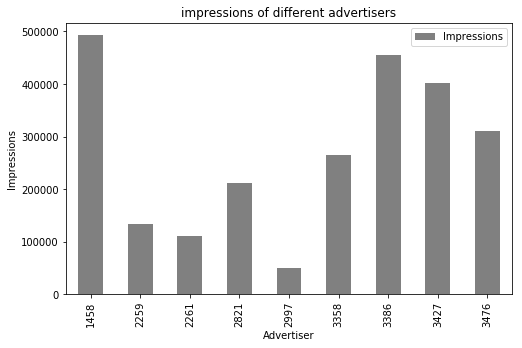

In [18]:
# Graph1 --- impressions of different advertisers
pic1 = dataset[['Impressions']]
pic1.plot(by='Advertiser', kind='bar', color = 'grey', figsize=(8,5))
plt.ylabel('Impressions')
plt.xlabel('Advertiser')
plt.title('impressions of different advertisers') 
plt.xticks((0,1,2,3,4,5,6,7,8),(u'1458',u'2259',u'2261',u'2821',u'2997',u'3358',u'3386',u'3427',u'3476'))
plt.show()


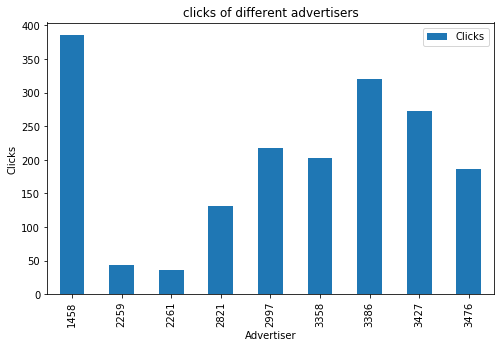

In [19]:
# Graph2 --- clicks of different advertisers
pic2 = dataset[['Clicks']]
pic2.plot(by='Advertiser',kind='bar',figsize=(8,5))
plt.ylabel('Clicks')
plt.xlabel('Advertiser')
plt.title('clicks of different advertisers')  
plt.xticks((0,1,2,3,4,5,6,7,8),(u'1458',u'2259',u'2261',u'2821',u'2997',u'3358',u'3386',u'3427',u'3476'))
plt.show()

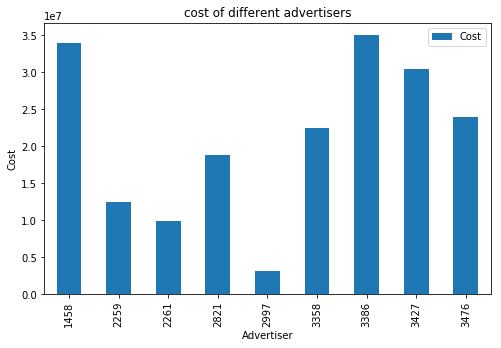

In [20]:
# Graph3 --- cost of different advertisers
pic3 = dataset[['Cost']]
pic3.plot(by='Advertiser',kind='bar',figsize=(8,5))
plt.ylabel('Cost')
plt.xlabel('Advertiser')
plt.title('cost of different advertisers')  
plt.xticks((0,1,2,3,4,5,6,7,8),(u'1458',u'2259',u'2261',u'2821',u'2997',u'3358',u'3386',u'3427',u'3476'))
plt.show()

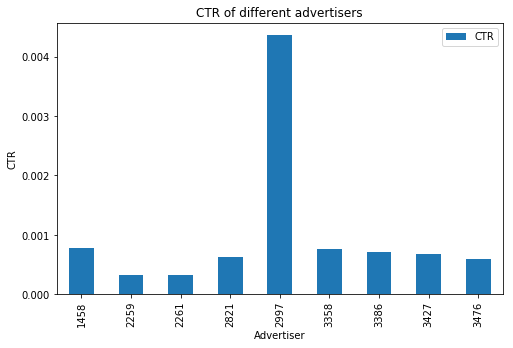

In [21]:
# Graph4 --- CTR of different advertisers
pic4 = dataset[['CTR']]
pic4.plot(by='Advertiser',kind='bar',figsize=(8,5))
plt.ylabel('CTR')
plt.xlabel('Advertiser')
plt.title('CTR of different advertisers')  
plt.xticks((0,1,2,3,4,5,6,7,8),(u'1458',u'2259',u'2261',u'2821',u'2997',u'3358',u'3386',u'3427',u'3476'))
plt.show()

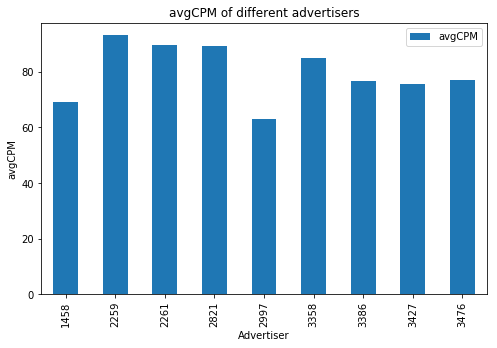

In [22]:
# Graph5 --- CPM of different advertisers
pic5 = dataset[['avgCPM']]
pic5.plot(by='Advertiser',kind='bar',figsize=(8,5))
plt.ylabel('avgCPM')
plt.xlabel('Advertiser')
plt.title('avgCPM of different advertisers')  
plt.xticks((0,1,2,3,4,5,6,7,8),(u'1458',u'2259',u'2261',u'2821',u'2997',u'3358',u'3386',u'3427',u'3476'))
plt.show()

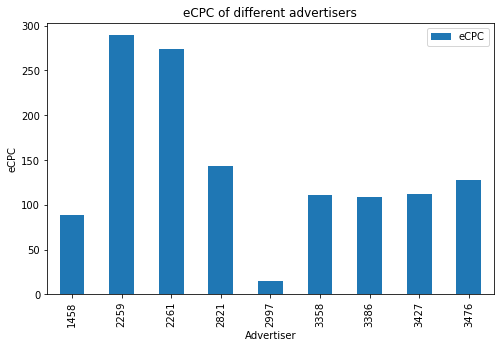

In [23]:
# Graph6 --- eCPC of different advertisers
pic6 = dataset[['eCPC']]
pic6.plot(by='Advertiser',kind='bar',figsize=(8,5))
plt.ylabel('eCPC')
plt.xlabel('Advertiser')
plt.title('eCPC of different advertisers')  
plt.xticks((0,1,2,3,4,5,6,7,8),(u'1458',u'2259',u'2261',u'2821',u'2997',u'3358',u'3386',u'3427',u'3476'))
plt.show()

## CTR Analysis —— 1458 V.S. 3358
### CTR against Weekday

In [24]:
daily_CTR = pd.DataFrame()
daily_CTR['weekday'] = np.sort(train.weekday.unique())

click = train.groupby('weekday').click.value_counts()

imp_1458 = train.groupby('weekday').advertiser.value_counts()
daily_CTR['imps_1458'] = imp_1458.iloc[imp_1458.index.get_level_values('advertiser') == 1458].values 

imp_3358 = train.groupby('weekday').advertiser.value_counts()
daily_CTR['imps_3358'] = imp_3358.iloc[imp_3358.index.get_level_values('advertiser') == 3358].values 

click = train.groupby(['advertiser','weekday']).click.value_counts()
clickall_1458 = click.iloc[click.index.get_level_values('advertiser') == 1458]
daily_CTR['clicks_1458'] = clickall_1458.iloc[clickall_1458.index.get_level_values('click') == 1].values

clickall_3358 = click.iloc[click.index.get_level_values('advertiser') == 3358]
daily_CTR['clicks_3358'] = clickall_3358.iloc[clickall_3358.index.get_level_values('click') == 1].values

daily_CTR['CTR_1458'] = ((daily_CTR.clicks_1458 / daily_CTR.imps_1458)*100).round(3)
daily_CTR['CTR_3358'] = ((daily_CTR.clicks_3358 / daily_CTR.imps_3358)*100).round(3)

daily_CTR

,weekday,imps_1458,imps_3358,clicks_1458,clicks_3358,CTR_1458,CTR_3358
0,0,76372,29504,52,22,0.068,0.075
1,1,66245,26723,63,16,0.095,0.060
2,2,67985,22569,48,6,0.071,0.027
3,3,68874,71058,52,73,0.076,0.103
4,4,69881,35638,62,27,0.089,0.076
5,5,71634,50651,62,38,0.087,0.075
6,6,71362,28813,46,20,0.064,0.069


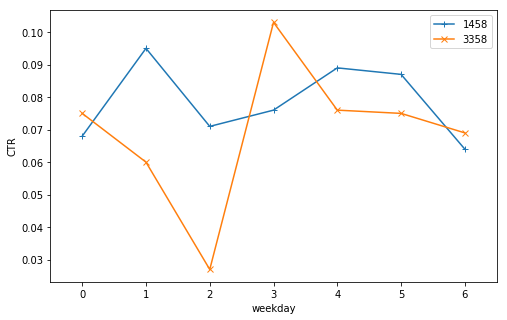

In [25]:
f, ax = plt.subplots(1)
ax.plot(daily_CTR.weekday.values, daily_CTR.CTR_1458.values, marker = '+', label='1458')
ax.plot(daily_CTR.weekday.values, daily_CTR.CTR_3358.values,marker='x', label='3358')
plt.legend()
plt.ylabel('CTR')
plt.xlabel('weekday')
ax.set_xlim(xmin = -0.5, xmax = 6.5)
f.set_size_inches(8,5)
plt.draw()
plt.show()

### CTR against Hour

In [26]:
hourly_CTR = pd.DataFrame()

hourly_CTR['hour'] = np.sort(train.hour.unique())

imp_1458 = train.groupby('hour').advertiser.value_counts()
hourly_CTR['imps_1458'] = imp_1458.iloc[imp_1458.index.get_level_values('advertiser') == 1458].values 

imp_3358 = train.groupby('hour').advertiser.value_counts()
hourly_CTR['imps_3358'] = imp_3358.iloc[imp_3358.index.get_level_values('advertiser') == 3358].values 

click = train.groupby(['advertiser','hour']).click.value_counts()
clickall_1458 = click.iloc[click.index.get_level_values('advertiser') == 1458]
hourly_CTR['clicks_1458'] = clickall_1458.iloc[clickall_1458.index.get_level_values('click') == 1].values

clickall_3358 = click.iloc[click.index.get_level_values('advertiser') == 3358]
click3358 = clickall_3358.iloc[clickall_3358.index.get_level_values('click') == 1].values
clickall_3358.iloc[clickall_3358.index.get_level_values('click') == 0]=0
hourly_CTR['clicks_3358'] = clickall_3358.groupby(level='hour').sum().values

hourly_CTR['CTR_1458'] = ((hourly_CTR.clicks_1458 / hourly_CTR.imps_1458) * 100).round(3)
hourly_CTR['CTR_3358'] = ((hourly_CTR.clicks_3358 / hourly_CTR.imps_3358) * 100).round(3)


hourly_CTR

,hour,imps_1458,imps_3358,clicks_1458,clicks_3358,CTR_1458,CTR_3358
0,0,22945,60073,23,38,0.100,0.063
1,1,9900,7002,6,4,0.061,0.057
2,2,6064,3142,7,4,0.115,0.127
3,3,6517,1345,3,2,0.046,0.149
4,4,3324,1245,3,0,0.090,0.000
5,5,3751,1072,6,2,0.160,0.187
6,6,4626,2359,4,0,0.086,0.000
7,7,9745,2568,7,2,0.072,0.078
8,8,14401,7149,13,2,0.090,0.028
9,9,18046,4104,16,2,0.089,0.049


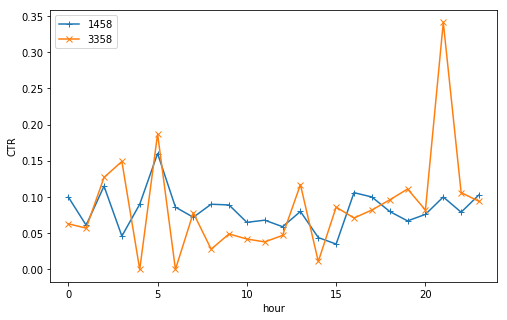

In [27]:
f, ax = plt.subplots(1)
ax.plot(hourly_CTR.hour.values, hourly_CTR.CTR_1458.values, marker = '+', label='1458')
ax.plot(hourly_CTR.hour.values, hourly_CTR.CTR_3358.values,marker='x', label='3358')
plt.legend(loc=2)
plt.ylabel('CTR')
plt.xlabel('hour')
ax.set_xlim(xmin = -1 , xmax = 24)
f.set_size_inches(8,5)
plt.draw()
plt.show()

### CTR against Region

In [28]:
region_CTR = pd.DataFrame()

region_CTR['region'] = np.sort(train.region.unique())

imp_1458 = train.groupby('region').advertiser.value_counts()
region_CTR['imps_1458'] = imp_1458.iloc[imp_1458.index.get_level_values('advertiser') == 1458].values 

imp_3358 = train.groupby('region').advertiser.value_counts()
region_CTR['imps_3358'] = imp_3358.iloc[imp_3358.index.get_level_values('advertiser') == 3358].values 

click = train.groupby(['advertiser','region']).click.value_counts()
clickall_1458 = click.iloc[click.index.get_level_values('advertiser') == 1458]
clickall_1458.iloc[clickall_1458.index.get_level_values('click') == 0]=0
region_CTR['clicks_1458'] = clickall_1458.groupby(level='region').sum().values

clickall_3358 = click.iloc[click.index.get_level_values('advertiser') == 3358]
clickall_3358.iloc[clickall_3358.index.get_level_values('click') == 0]=0
region_CTR['clicks_3358'] = clickall_3358.groupby(level='region').sum().values

region_CTR['CTR_1458'] = ((region_CTR.clicks_1458 / region_CTR.imps_1458) * 100).round(3)
region_CTR['CTR_3358'] = ((region_CTR.clicks_3358 / region_CTR.imps_3358) * 100).round(3)

region_CTR

,region,imps_1458,imps_3358,clicks_1458,clicks_3358,CTR_1458,CTR_3358
0,0,7131,5577,6,10,0.084,0.179
1,1,21360,10449,17,11,0.080,0.105
2,2,7969,4252,4,4,0.050,0.094
3,3,24605,11299,21,6,0.085,0.053
4,15,15076,7016,15,8,0.099,0.114
5,27,7050,3284,3,2,0.043,0.061
6,40,18564,7837,11,3,0.059,0.038
7,55,11053,4254,5,2,0.045,0.047
8,65,11692,4929,12,3,0.103,0.061
9,79,12974,8359,14,5,0.108,0.060


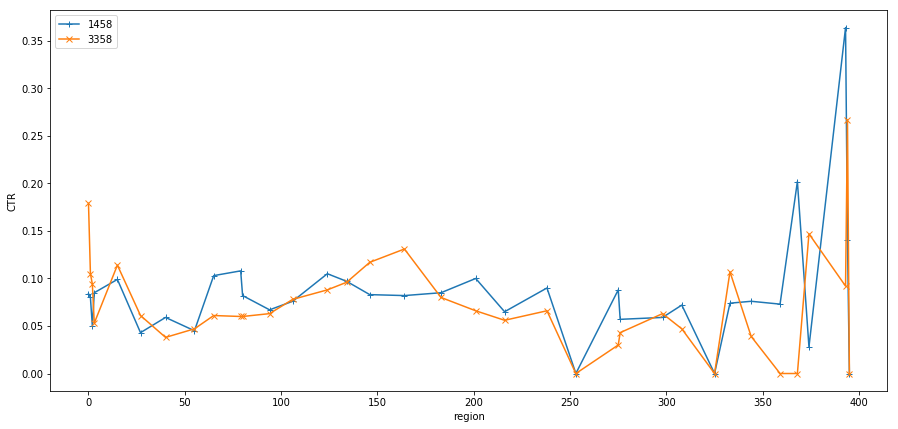

In [29]:
f, ax = plt.subplots(1)
ax.plot(region_CTR.region.values, region_CTR.CTR_1458.values, marker = '+', label='1458')
ax.plot(region_CTR.region.values, region_CTR.CTR_3358.values,marker='x', label='3358')
plt.legend(loc=2)
plt.ylabel('CTR')
plt.xlabel('region')
#ax.set_xlim(xmin = -2 , xmax = 402)
f.set_size_inches(15,7)
plt.draw()
plt.show()

### CTR against Ad_exchange

In [30]:
adexchange_CTR = pd.DataFrame()

adexchange_CTR['ad_exchange'] = np.sort(train.adexchange.unique())
adexchange_CTR

,ad_exchange
0,1
1,2
2,3
3,4
4,null


In [31]:
adexchange_CTR = pd.DataFrame()

adexchange_CTR['ad_exchange'] = np.sort(train.adexchange.unique())
adexchange_CTR = adexchange_CTR.drop([3,4])
imp_1458 = train.groupby('adexchange').advertiser.value_counts()
adexchange_CTR['imps_1458'] = imp_1458.iloc[imp_1458.index.get_level_values('advertiser') == 1458].values 

imp_3358 = train.groupby('adexchange').advertiser.value_counts()
adexchange_CTR['imps_3358'] = imp_3358.iloc[imp_3358.index.get_level_values('advertiser') == 3358].values 

click = train.groupby(['advertiser','adexchange']).click.value_counts()
clickall_1458 = click.iloc[click.index.get_level_values('advertiser') == 1458]
clickall_1458.iloc[clickall_1458.index.get_level_values('click') == 0]=0
adexchange_CTR['clicks_1458'] = clickall_1458.groupby(level='adexchange').sum().values

clickall_3358 = click.iloc[click.index.get_level_values('advertiser') == 3358]
clickall_3358.iloc[clickall_3358.index.get_level_values('click') == 0]=0
adexchange_CTR['clicks_3358'] = clickall_3358.groupby(level='adexchange').sum().values

adexchange_CTR['CTR_1458'] = ((adexchange_CTR.clicks_1458 / adexchange_CTR.imps_1458) * 100).round(3)
adexchange_CTR['CTR_3358'] = ((adexchange_CTR.clicks_3358 / adexchange_CTR.imps_3358) * 100).round(3)


adexchange_CTR

,ad_exchange,imps_1458,imps_3358,clicks_1458,clicks_3358,CTR_1458,CTR_3358
0,1,166065,133697,134,119,0.081,0.089
1,2,146513,84300,115,38,0.078,0.045
2,3,179775,46959,136,45,0.076,0.096


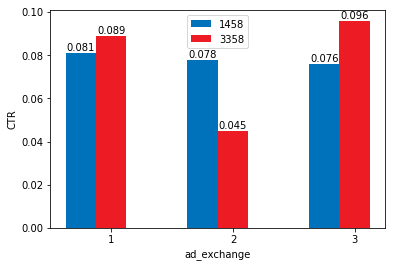

In [32]:
ad_exchange=adexchange_CTR['ad_exchange']
bar_width=0.25

index = np.arange(len(adexchange_CTR['CTR_1458']))
rects1 = plt.bar(index, adexchange_CTR['CTR_1458'], bar_width, color='#0072BC', label='1458')
rects2 = plt.bar(index + bar_width, adexchange_CTR['CTR_3358'], bar_width, color='#ED1C24', label='3358')

plt.xticks(index + bar_width, ad_exchange)
plt.legend()
plt.ylabel('CTR')
plt.xlabel('ad_exchange')

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height, height, ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

### CTR against OS

In [33]:
OS_CTR = pd.DataFrame()
os_browser = pd.DataFrame(train.useragent.str.split('_',1).tolist(),columns = ['OS','browser'])
train = pd.concat([train,os_browser],axis=1)

OS_CTR['OS'] = np.sort(train.OS.unique())
imp_1458 = train.groupby('OS').advertiser.value_counts()
OS_CTR['imps_1458'] = imp_1458.iloc[imp_1458.index.get_level_values('advertiser') == 1458].values 

imp_3358 = train.groupby('OS').advertiser.value_counts()
imp_3358 = list(imp_3358.iloc[imp_3358.index.get_level_values('advertiser') == 3358].values)
OS_CTR['imps_3358'] = imp_3358

click = train.groupby(['advertiser','OS']).click.value_counts()
clickall_1458 = click.iloc[click.index.get_level_values('advertiser') == 1458]
clickall_1458.iloc[clickall_1458.index.get_level_values('click') == 0]=0
OS_CTR['clicks_1458'] = clickall_1458.groupby(level='OS').sum().values

clickall_3358 = click.iloc[click.index.get_level_values('advertiser') == 3358]
clickall_3358.iloc[clickall_3358.index.get_level_values('click') == 0]=0
clickall_3358 = list(clickall_3358.groupby(level='OS').sum().values)
OS_CTR['clicks_3358'] = clickall_3358

OS_CTR['CTR_1458'] = ((OS_CTR.clicks_1458 / OS_CTR.imps_1458) * 100).round(3)
OS_CTR['CTR_3358'] = ((OS_CTR.clicks_3358 / OS_CTR.imps_3358) * 100).round(3)

In [34]:
OS_CTR

,OS,imps_1458,imps_3358,clicks_1458,clicks_3358,CTR_1458,CTR_3358
0,android,3185,3800,14,18,0.440,0.474
1,ios,79,66,1,0,1.266,0.000
2,linux,268,198,0,1,0.000,0.505
3,mac,10357,9610,32,38,0.309,0.395
4,other,739,189,0,0,0.000,0.000
5,windows,477725,251093,338,145,0.071,0.058


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c4fa0b4e0>],
      dtype=object)

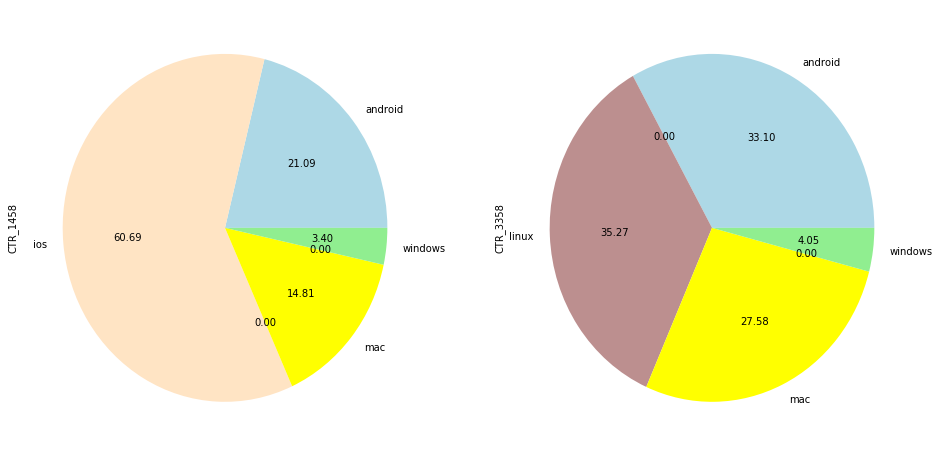

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
color=['#ADD8E6', '#FFE4C4','#BC8F8F','yellow', '#90EE90','lightgreen','purple','aqua','silver','lime','teal','blue']

a1=OS_CTR[['OS','CTR_1458']]
a1 = a1.set_index('OS')
a1.plot(subplots=True, kind='pie',ax=axes[0],colors=color, autopct='%0.2f',legend=False)
a2 = OS_CTR[['OS','CTR_3358']]
a2 = a2.set_index('OS')
a2.plot(subplots=True, kind='pie',ax=axes[1], colors=color ,autopct='%0.2f',legend=False)

### CTR against Browser

In [36]:
browser_CTR = pd.DataFrame()

browser_CTR['browser'] = np.sort(train.browser.unique())
imp_1458 = train.groupby('browser').advertiser.value_counts()
browser_CTR['imps_1458'] = imp_1458.iloc[imp_1458.index.get_level_values('advertiser') == 1458].values 

imp_3358 = train.groupby('browser').advertiser.value_counts()
imp_3358 = list(imp_3358.iloc[imp_3358.index.get_level_values('advertiser') == 3358].values)
browser_CTR['imps_3358'] = imp_3358

click = train.groupby(['advertiser','browser']).click.value_counts()
clickall_1458 = click.iloc[click.index.get_level_values('advertiser') == 1458]
clickall_1458.iloc[clickall_1458.index.get_level_values('click') == 0]=0
browser_CTR['clicks_1458'] = clickall_1458.groupby(level='browser').sum().values

clickall_3358 = click.iloc[click.index.get_level_values('advertiser') == 3358]
clickall_3358.iloc[clickall_3358.index.get_level_values('click') == 0]=0
clickall_3358 = list(clickall_3358.groupby(level='browser').sum().values)
browser_CTR['clicks_3358'] = clickall_3358

browser_CTR['CTR_1458'] = ((browser_CTR.clicks_1458 / browser_CTR.imps_1458) * 100).round(3)
browser_CTR['CTR_3358'] = ((browser_CTR.clicks_3358 / browser_CTR.imps_3358) * 100).round(3)

browser_CTR

,browser,imps_1458,imps_3358,clicks_1458,clicks_3358,CTR_1458,CTR_3358
0,chrome,147685,85445,94,41,0.064,0.048
1,firefox,3635,3059,2,2,0.055,0.065
2,ie,320368,159384,241,100,0.075,0.063
3,maxthon,1233,788,0,1,0.000,0.127
4,opera,456,429,0,0,0.000,0.000
5,other,4666,3878,4,11,0.086,0.284
6,safari,11555,10435,43,46,0.372,0.441
7,sogou,5,8,0,0,0.000,0.000
8,theworld,2750,1530,1,1,0.036,0.065


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c6213bc88>],
      dtype=object)

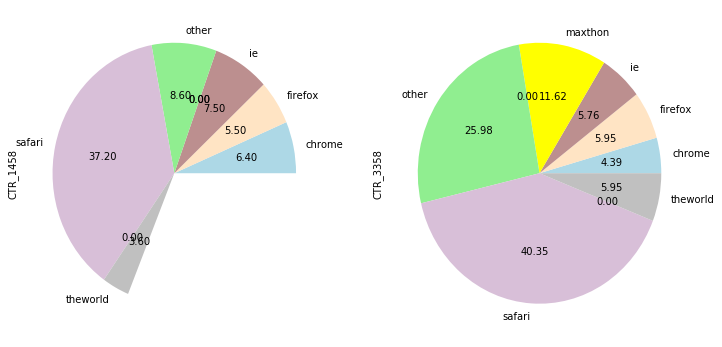

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
color=['#ADD8E6', '#FFE4C4','#BC8F8F','yellow', '#90EE90','lightgreen','thistle','aqua','silver','lime','teal','blue']

a3= browser_CTR[['browser','CTR_1458']]
a3 = a3.set_index('browser')
a3.plot(subplots=True, kind='pie',ax=axes[0], colors=color, autopct='%0.2f',legend=False)

a4 = browser_CTR[['browser','CTR_3358']]
a4 = a4.set_index('browser')
a4.plot(subplots=True, kind='pie',ax=axes[1], colors=color, autopct='%0.2f',legend=False)

In [48]:
slotsize_CTR = pd.DataFrame()

slotsize_CTR['slotsize'] = np.sort(train.slotsize.unique())
imp_1458 = train.groupby('slotsize').advertiser.value_counts()
a = imp_1458.iloc[imp_1458.index.get_level_values('advertiser') == 1458].index.get_level_values(0)
b= pd.DataFrame(list(set(slotsize_CTR.slotsize.tolist())-set(a)))
c = pd.DataFrame(imp_1458.iloc[imp_1458.index.get_level_values('advertiser') == 1458].index.get_level_values(0).tolist())
c['values'] = imp_1458.iloc[imp_1458.index.get_level_values('advertiser') == 1458].values
d = pd.concat([c,b]).fillna(0)
d.columns = ['slotsize','values']
slotsize_CTR['values'] = 0
e = slotsize_CTR.merge(d,on='slotsize')
e = e.drop('values_x',axis=1)
e.values_y = e.values_y.astype(int)
slotsize_CTR['imps_1458'] = e.values_y

slotsize_CTR['slotsize'] = np.sort(train.slotsize.unique())
imp_3358 = train.groupby('slotsize').advertiser.value_counts()
a = imp_3358.iloc[imp_3358.index.get_level_values('advertiser') == 3358].index.get_level_values(0)
b= pd.DataFrame(list(set(slotsize_CTR.slotsize.tolist())-set(a)))
c = pd.DataFrame(imp_3358.iloc[imp_3358.index.get_level_values('advertiser') == 3358].index.get_level_values(0).tolist())
c['values'] = imp_3358.iloc[imp_3358.index.get_level_values('advertiser') == 3358].values
d = pd.concat([c,b]).fillna(0)
d.columns = ['slotsize','values']
slotsize_CTR['values'] = 0
e = slotsize_CTR.merge(d,on='slotsize')
e = e.drop('values_x',axis=1)
e.values_y = e.values_y.astype(int)
slotsize_CTR['imps_3358'] = e.values_y
slotsize_CTR = slotsize_CTR.drop('values',axis=1)

AttributeError: 'DataFrame' object has no attribute 'slotsize'

In [ ]:
click = train.groupby(['advertiser','slotsize']).click.value_counts()
clickall_1458 = click.iloc[click.index.get_level_values('advertiser') == 1458]
clickall_1458.iloc[clickall_1458.index.get_level_values('click') == 0]=0
a=pd.DataFrame(clickall_1458.groupby(level='slotsize').sum().index.get_level_values(0))
b=pd.DataFrame(clickall_1458.groupby(level='slotsize').sum().values)
c=pd.concat([a,b],axis=1)
c.columns = ['slotsize','clicks_1458']
slotsize_CTR = slotsize_CTR.merge(c,how='outer',on='slotsize').fillna(0)
slotsize_CTR = slotsize_CTR.drop(['clicks_1458_x','clicks_1458_y'], axis=1)
slotsize_CTR.clicks_1458 = slotsize_CTR.clicks_1458.astype(int)

In [ ]:
clickall_3358 = click.iloc[click.index.get_level_values('advertiser') == 3358]
clickall_3358.iloc[clickall_3358.index.get_level_values('click') == 0]=0
a=pd.DataFrame(clickall_3358.groupby(level='slotsize').sum().index.get_level_values(0))
b=pd.DataFrame(clickall_3358.groupby(level='slotsize').sum().values)
c=pd.concat([a,b],axis=1)
c.columns = ['slotsize','clicks_3358']
slotsize_CTR = slotsize_CTR.merge(c,how='outer',on='slotsize').fillna(0)
slotsize_CTR = slotsize_CTR.drop(['clicks_3358_x','clicks_3358_y'], axis=1)
slotsize_CTR.clicks_3358 = slotsize_CTR.clicks_3358.astype(int)

slotsize_CTR['CTR_1458'] = ((slotsize_CTR.clicks_1458 / slotsize_CTR.imps_1458) * 100).round(3)
slotsize_CTR['CTR_3358'] = ((slotsize_CTR.clicks_3358 / slotsize_CTR.imps_3358) * 100).round(3)
slotsize_CTR = slotsize_CTR.fillna(0)

In [ ]:
a1=slotsize_CTR[['slotsize','CTR_1458']]
ax1 = a1.plot(x=a1.slotsize,kind='bar',color='black',position=1,width = 0.4, figsize=(12,5))
a2 = slotsize_CTR[['slotsize','CTR_3358']]
a2.plot(x=a1.slotsize, kind='bar',color='silver', ax=ax1,width = 0.4, position=2)